In [104]:
! pip install markov_clustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
import requests
import time

import pandas as pd
import numpy as np
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import networkx as nx
import markov_clustering as mc
import pickle

id выбранных сообществ

In [106]:
id1 = 'zhivoy_espanol'
id2 = 'yosoycomosoy'

##Списки участников

Получим и сохраним списки подписчиков двух пабликов

In [107]:
tokk = '996f029b996f029b996f029bed9a7f63b69996f996f029bfb91882464ff505035eae8f0'

In [ ]:
def get_members(groupid):
  users1 = requests.get('https://api.vk.com/method/groups.getMembers', params={
            'access_token':tokk,
            'v':5.103,
            'group_id': groupid,
            'sort':'id_desc',
        }).json()
  data = users1['response']['items']
  num = users1['response']['count'] // 1000
  for i in range(1, num+1):
    users2 = requests.get('https://api.vk.com/method/groups.getMembers', params={
            'access_token':tokk,
            'v':5.103,
            'group_id': groupid,
            'sort':'id_desc',
            'offset':i*1000,
        }).json()

    data = data + users2['response']['items']
  return data

In [ ]:
users1 = get_members(id1)

In [ ]:
users2 = get_members(id2)

In [ ]:
with open('/content/drive/MyDrive/6/СС/1/another_users1.pickle', 'wb') as handle:
        pickle.dump(users1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/6/СС/1/another_users2.pickle', 'wb') as handle:
        pickle.dump(users2, handle, protocol=pickle.HIGHEST_PROTOCOL)

Количество людей, подписанных на оба паблика

In [ ]:
len(set(users1)&set(users2))

71

##Посты сообществ

Получим посты обоих пабликов

In [ ]:
def get_posts(group):
  posts = []
  groupid = requests.get('https://api.vk.com/method/utils.resolveScreenName', params={
            'access_token':tokk,
            'v':5.103,
            'screen_name': group
        }).json()['response']['object_id']
  for a in range(20):
    posts_new = requests.get('https://api.vk.com/method/wall.get', params={
            'access_token':tokk,
            'v':5.103,
            'owner_id': -groupid,
            'offset': 100*a,
            'count': 100,
        }).json()['response']['items']
    posts.extend(posts_new)
    time.sleep(0.35)
  return posts

In [ ]:
posts1 = get_posts(id1)

In [ ]:
posts2 = get_posts(id2)

In [115]:
len(posts1)

647

In [116]:
len(posts2)

977

##Анализ тегов сообществ


Выбираем интересующие нас поля для последующего анализа и найдем теги

In [ ]:
posts1[1].keys()

dict_keys(['id', 'from_id', 'owner_id', 'date', 'marked_as_ads', 'post_type', 'text', 'attachments', 'comments', 'likes', 'reposts', 'views', 'edited', 'hash'])

id, date, text

In [ ]:
def turn_to_pd(posts):
  ids = []
  dates = []
  texts = []
  tags = []
  for i in range(len(posts)):
    ids.append(posts[i]['id'])
    dates.append(posts[i]['date'])
    texts.append(posts[i]['text'])
    tags.extend(re.findall('#\w+', posts[i]['text']))

  posts_df = pd.DataFrame.from_dict({
    'post_id': ids,
    'post_date': dates,
    'text': texts
    })
  posts_df['post_date'] = pd.to_datetime(posts_df['post_date'], unit='s')
  
  return posts_df, tags

In [ ]:
posts1_df, tagslist1 = turn_to_pd(posts1)

In [ ]:
posts2_df, tagslist2 = turn_to_pd(posts2)

In [ ]:
posts1_df.head()

post_id           post_date  \
0     4273 2022-08-21 15:19:02   
1     4301 2022-08-31 14:12:02   
2     4298 2022-08-31 09:00:31   
3     4293 2022-08-28 13:06:01   
4     4290 2022-08-27 19:02:25   

                                                text  
0  Магия Арбата  - Экскурсии по Москве на испанск...  
1  Экскурсии на испанском  ☀️ \n\nПотихоньку наст...  
2  UNIVERSIDADES EN ESPAÑA \n \nАмигос, уже совсе...  
3  LA SIESTA 😴 Это волшебное слово «сиеста»\n\nAm...  
4  💫Видео для практики испанского💫\n\n,Agencia EL...

In [ ]:
posts2_df.head()

post_id           post_date  \
0     2098 2019-05-10 14:57:51   
1     2091 2019-04-25 20:09:18   
2     2086 2019-04-17 14:53:00   
3     2084 2019-04-11 20:21:41   
4     2081 2018-08-29 17:21:00   

                                                text  
0  Мы готовим несколько мини-курсов испанского яз...  
1  Как спрашивают "Как дела, друг?" в разных стра...  
2  "Este trabajo será pan comido para tí"\nЧто эт...  
3  Философско-танцевальная песня популярного доми...  
4  #test@yosoycomosoy \n\nВыберите подходящий вар...

Количество тегов

In [ ]:
len(tagslist1)

994

In [ ]:
len(tagslist2)

1190

Очистим первый список тегов от названия паблика

In [ ]:
tagslist1 = [re.sub('живойиспанский_', '', i) for i in tagslist1]

Одинаковые теги

In [ ]:
common_tags=set(tagslist1)&set(tagslist2)
common_tags

{'#audio',
 '#canciones',
 '#cultura',
 '#dele',
 '#fiestas',
 '#frases',
 '#gramatica',
 '#gramática',
 '#lectura',
 '#libros',
 '#musica',
 '#palabras',
 '#videos',
 '#vocabulario',
 '#марафон'}

Самые частые хэштеги

In [ ]:
hashtags1 = dict(Counter(tagslist1))
tags1 = dict(Counter(tagslist1).most_common(10))
tags1

{'#vocabulario': 142,
 '#peliculas': 125,
 '#cultura': 84,
 '#gramatica': 61,
 '#videos': 49,
 '#viajes': 37,
 '#libros': 34,
 '#марафоны': 31,
 '#марафон': 27,
 '#endetalle': 26}

In [ ]:
hashtags2 = dict(Counter(tagslist2))
tags2 = dict(Counter(tagslist2).most_common(10))
tags2

{'#vocabulario': 92,
 '#test': 83,
 '#video': 82,
 '#test2': 70,
 '#vocabulario2': 70,
 '#humor': 63,
 '#vocabulario1': 59,
 '#frases': 56,
 '#test1': 49,
 '#audio': 43}

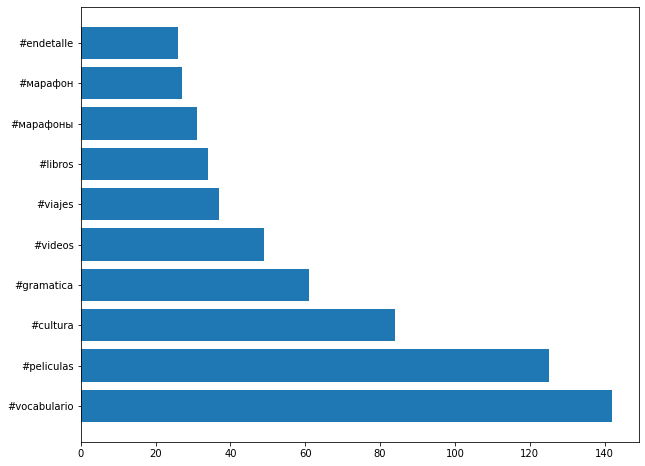

In [ ]:
rcParams["figure.figsize"] = 10,8
plt.barh(range(10), list(tags1.values()), tick_label=list(tags1.keys()))
plt.show()

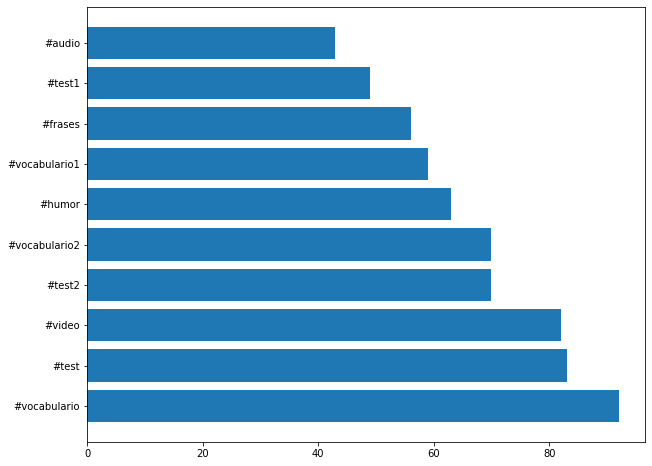

In [ ]:
rcParams["figure.figsize"] = 10,8
plt.barh(range(10), list(tags2.values()), tick_label=list(tags2.keys()))
plt.show()

Совпадают два самых популярных тега: vocabulario и video

##Анализ времени активности

In [ ]:
hours1 = posts1_df['post_date'].dt.hour.value_counts().sort_index()
hours1

4      2
5      4
6     12
7     56
8     71
9     48
10    21
11     9
12     8
13    14
14    35
15    76
16    98
17    89
18    75
19    25
20     3
21     1
Name: post_date, dtype: int64

Дополним недостающие значения

In [ ]:
hours1[0] = 0
hours1[1] = 0
hours1[2] = 0
hours1[3] = 0
hours1[22] = 0
hours1[23] = 0

In [ ]:
hours2 = posts2_df['post_date'].dt.hour.value_counts().sort_index()
hours2

0      1
1      1
3      2
4      7
5     27
6     36
7     59
8     72
9     55
10    84
11    74
12    76
13    53
14    76
15    54
16    92
17    67
18    64
19    40
20    31
21     4
22     2
Name: post_date, dtype: int64

In [ ]:
hours2[2] = 0
hours2[23] = 0

In [ ]:
dict_for_graph = dict(x=list(range(24)), y1=hours1.values, y2=hours2.values)
data = pd.DataFrame(dict_for_graph)

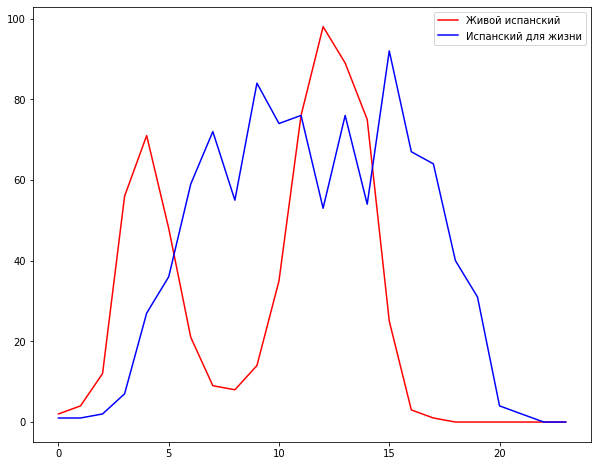

In [ ]:
plt.plot(list(range(24)), hours1.values, color='r', label='Живой испанский')
plt.plot(list(range(24)), hours2.values, color='b', label='Испанский для жизни')
plt.legend();

У первого сообщества наблюдается 2 пика активности: рано утром и днем. Активность во второй группе более равномерна в течение дня и почти отсутствует ночью. Совпадение времени наибольшей активности двух групп: с 13 до 19 часов.

##Друзья участников сообществ

In [ ]:
def get_friends(members):
  friends = {}
  i = 0
  for member in members:#[712945268,720451621,741059199,730979354]:
    friends[member] = []
    member_friends = requests.get('https://api.vk.com/method/friends.get', params={
             'access_token':tokk,
             'v':5.103,
             'user_id': member
             }).json()
    i += 1
    if i%10==0:
      print(i)

    if 'error' in member_friends.keys():
      pass
    else:
      friends[member] = member_friends['response']['items']
    time.sleep(0.35)
  return friends

In [ ]:
friends1 = get_friends(users1)

In [ ]:
with open('/content/drive/MyDrive/6/СС/1/another_friends1.pickle', 'wb') as handle:
        pickle.dump(friends1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
friends2 = get_friends(users2)

In [103]:
with open('/content/drive/MyDrive/6/СС/1/another_friends2.pickle', 'wb') as handle:
        pickle.dump(friends2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/6/СС/1/friends2.pickle', 'rb') as handle:
    friends2 = pickle.load(handle)

##Построим графы обоих пабликов

In [ ]:
def get_edges(members, friends):
  edges = []
  for m in members:
    if m in friends.keys():
      m_fr_list = friends[m]
      if len(m_fr_list) > 0:
        for f in m_fr_list:
          if (f in members) and ((f, m) not in edges):
            edges.append((m, f))
  return edges

In [ ]:
edges1 = get_edges(users1, friends1)

In [108]:
edges2 = get_edges(users2, friends2)

In [109]:
common_users=set(users1)&set(users2)

In [117]:
def draw_graph(edges, common_users, title=''):
  graph = nx.Graph()
  graph.add_edges_from(edges)
  color_map = []
  node_sizes = []
  for node in graph:
    if node in common_users:
      color_map.append('red')
      node_sizes.append(20)
    else:
      color_map.append('green')
      node_sizes.append(10)
  fig, ax = plt.subplots(figsize=(13,13))
  nx.draw(graph, node_color=color_map, with_labels=False,
          node_size=node_sizes)
  plt.title(title);
  return graph

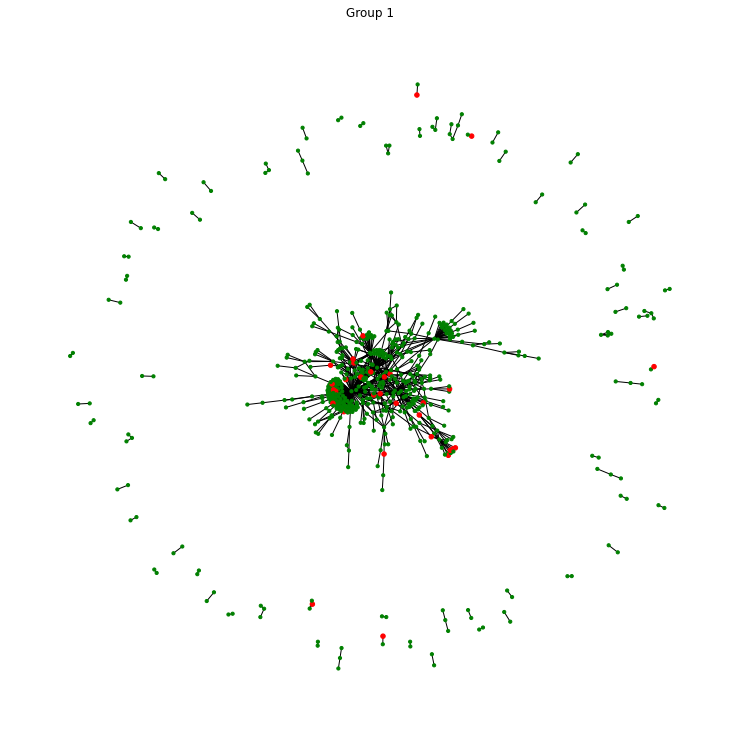

In [118]:
graph1 = draw_graph(edges1, common_users, 'Group 1')

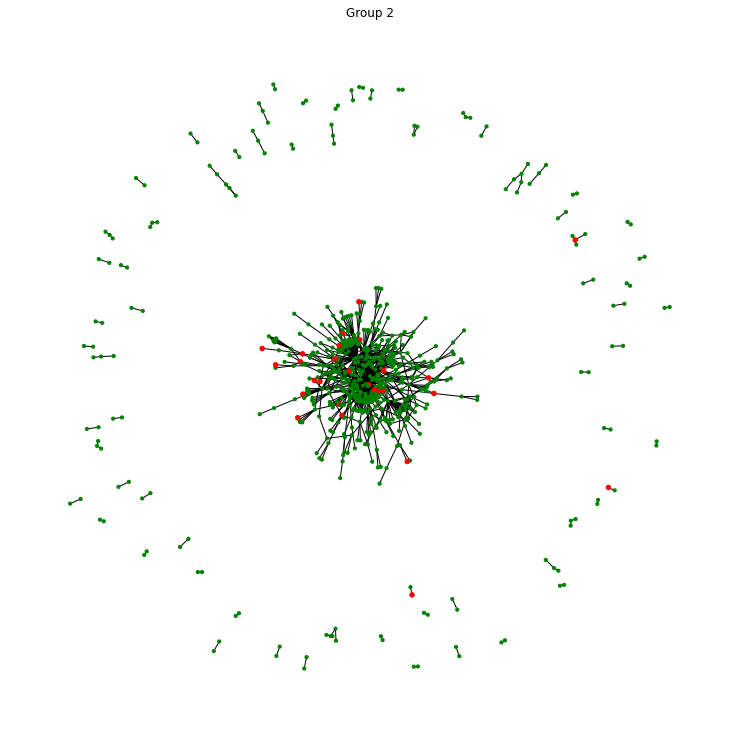

In [119]:
graph2 = draw_graph(edges2, common_users, 'Group 2')

Количество узлов и ребер в каждом графе

In [ ]:
print('Nodes of 1st: ', len(graph1.nodes))
print('Edges of 1st: ', len(graph1.edges))

Nodes of 1st:  600
Edges of 1st:  737


In [112]:
print('Nodes of 2nd: ', len(graph2.nodes))
print('Edges of 2nd: ', len(graph2.edges))

Nodes of 2nd:  639
Edges of 2nd:  779


##Кластеризация

In [126]:
def markov(graph):
  matrix = nx.to_scipy_sparse_matrix(graph)
  result = mc.run_mcl(matrix)
  clusters = mc.get_clusters(result)
  print('Количество кластеров в графе: ', len(clusters))
  fig, ax = plt.subplots(figsize=(13,13))
  mc.draw_graph(matrix, clusters, node_size=9, with_labels=False, cmap='gist_rainbow')

Количество кластеров в графе:  147


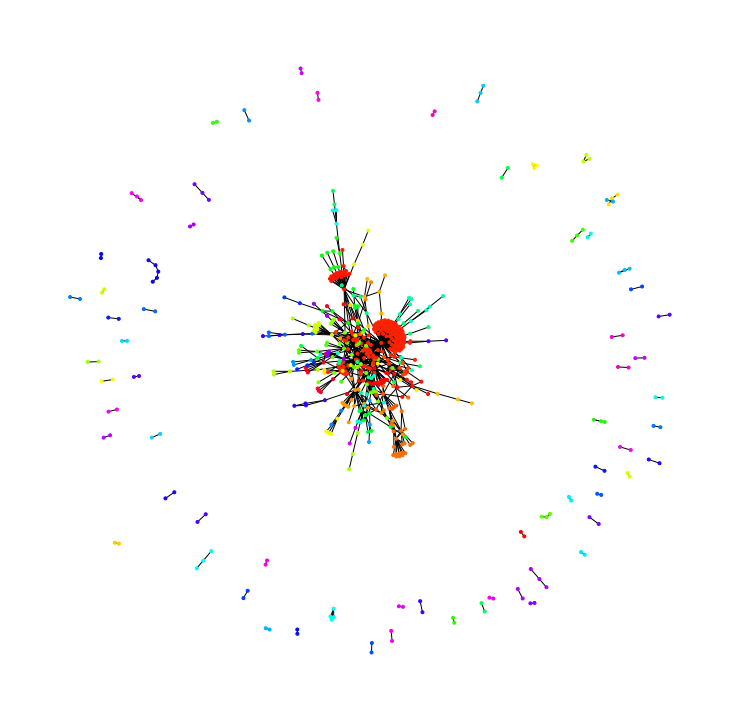

In [127]:
markov(graph1)

Количество кластеров в графе:  174


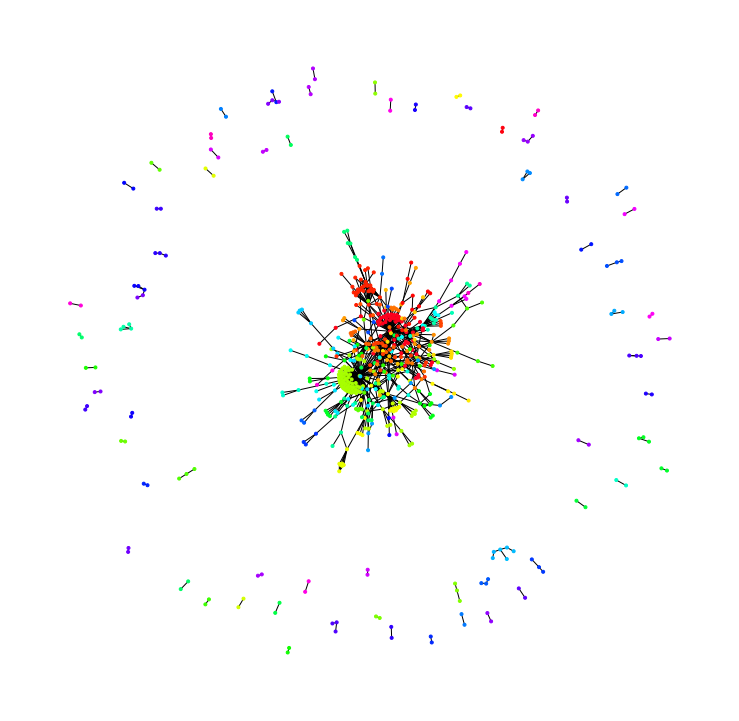

In [128]:
markov(graph2)

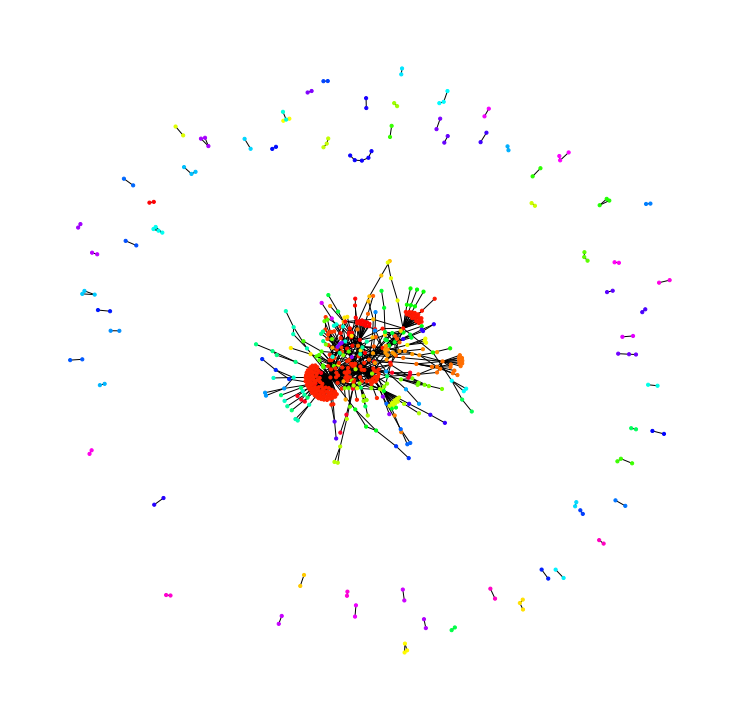

In [ ]:
matrix1 = nx.to_scipy_sparse_matrix(graph1)
result1 = mc.run_mcl(matrix1)
clusters1 = mc.get_clusters(result1)
fig, ax = plt.subplots(figsize=(13,13))
mc.draw_graph(matrix1, clusters1, node_size=10, with_labels=False, cmap='gist_rainbow')

In [ ]:
print('Количество кластеров 1 группы: ', len(clusters1))

Количество кластеров 1 группы: 147


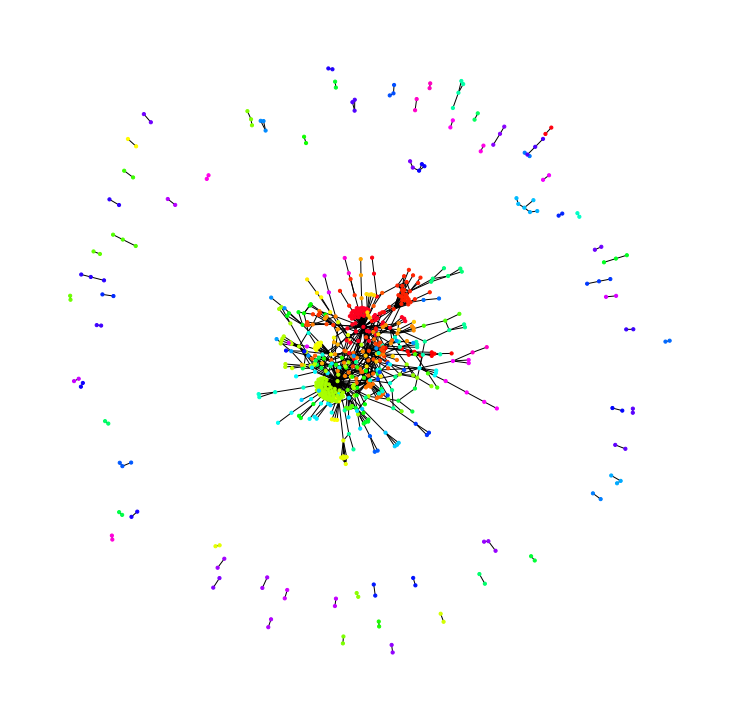

In [113]:
matrix2 = nx.to_scipy_sparse_matrix(graph2)
result2 = mc.run_mcl(matrix2)
clusters2 = mc.get_clusters(result2)
fig, ax = plt.subplots(figsize=(13,13))
mc.draw_graph(matrix2, clusters2, node_size=10, with_labels=False, cmap='gist_rainbow')

In [114]:
print('Количество кластеров 2 группы: ', len(clusters2))

Количество кластеров 2 группы:  174
